In [ ]:
# import all libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


In [ ]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [ ]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
print(len(trainset), len(testset))

73257 26032


In [ ]:
# Training
def train(epoch, net, criterion, trainloader, scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

Test performance on the test set. Note the use of `torch.inference_mode()`

In [ ]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [ ]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [ ]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


[3234. 8926. 6868. 5501. 4828. 4429. 3753. 3516. 3233. 2937.]
[0.06848068 0.18901006 0.14543145 0.11648491 0.10223399 0.09378507
 0.07947062 0.07445209 0.0684595  0.06219164]


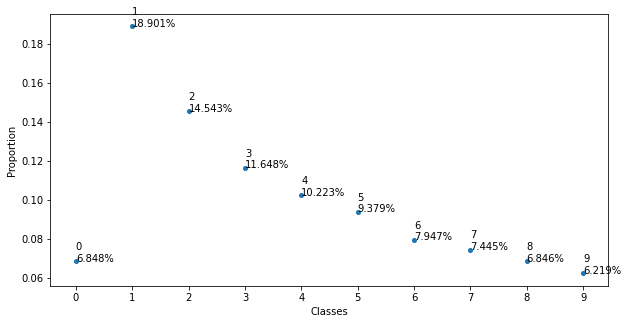

In [ ]:
# partition the trainset
torch.manual_seed(0)
np.random.seed(0)
new_trainset, validationset= torch.utils.data.random_split(trainset,
  [len(trainset)-len(testset), len(testset)], generator=torch.Generator().manual_seed(0))
class_freq = np.zeros(10)
for i in range(len(new_trainset)):
  class_freq[new_trainset[i][1]]+=1
class_prop = class_freq/(len(new_trainset))
print(class_freq)
print(class_prop)

# plot the proportion
ax = plt.figure(figsize=(10,5)).add_subplot(111)
plt.plot(list(classes),class_prop, '.', ms=8)
plt.xlabel("Classes")
plt.ylabel("Proportion")
for i,j in zip(list(classes),class_prop):
    ax.annotate(i+'\n'+str(round(j*100,3))+'%',xy=(i,j))
plt.show()

In [ ]:
sum(class_freq)

47225.0

In [ ]:
# main body
config = {
    'lr': 0.001,
    'weight_decay': 5e-4
}


trainloader = torch.utils.data.DataLoader(
        new_trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
        validationset, batch_size=128, shuffle=False, num_workers=2)
net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
#scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30)
#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=300)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

train_loss_list=[] 
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

for epoch in range(1, 301):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    train_loss_list.append(train_loss) 
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))



Epoch: 1
iteration :  50, loss : 2.3439, accuracy : 16.98
iteration : 100, loss : 2.2795, accuracy : 19.23
iteration : 150, loss : 2.1878, accuracy : 22.60
iteration : 200, loss : 2.0178, accuracy : 28.35
iteration : 250, loss : 1.8353, accuracy : 35.16
iteration : 300, loss : 1.6640, accuracy : 41.48
iteration : 350, loss : 1.5272, accuracy : 46.56
Epoch :   1, training loss : 1.4802, training accuracy : 48.28, test loss : 0.8332, test accuracy : 73.41

Epoch: 2
iteration :  50, loss : 0.5901, accuracy : 81.06
iteration : 100, loss : 0.5778, accuracy : 81.60
iteration : 150, loss : 0.5600, accuracy : 82.21
iteration : 200, loss : 0.5468, accuracy : 82.66
iteration : 250, loss : 0.5323, accuracy : 83.04
iteration : 300, loss : 0.5221, accuracy : 83.37
iteration : 350, loss : 0.5173, accuracy : 83.54
Epoch :   2, training loss : 0.5146, training accuracy : 83.64, test loss : 0.6243, test accuracy : 79.92

Epoch: 3
iteration :  50, loss : 0.4377, accuracy : 86.19
iteration : 100, loss :

In [ ]:
# the hold-out test set
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)
test_loss, test_acc = test(0, net, criterion, testloader)
test_loss, test_acc

(0.26001455211171914, 95.02919483712354)

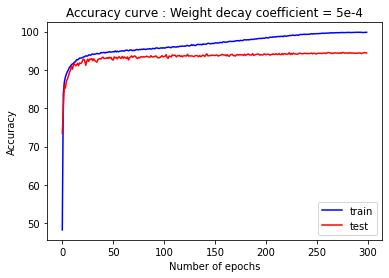

In [ ]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curve : Weight decay coefficient = 5e-4")
plt.legend(['train', 'test'])
plt.show()

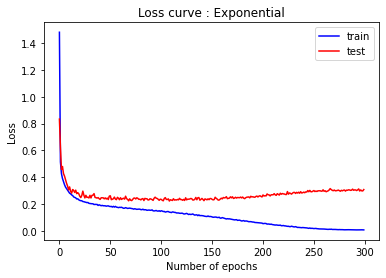

In [ ]:
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss curve : Exponential")
plt.legend(['train', 'test'])
plt.show()

In [ ]:
print(f"train_loss_list_exp = {train_loss_list}") 
print(f"train_acc_list_exp = {train_acc_list}")
print(f"test_loss_list_exp = {test_loss_list}")
print(f"test_acc_list_exp = {test_acc_list}")

train_loss_list_exp = [1.4802386524877573, 0.5145602391825782, 0.4270873037860969, 0.3911595640143728, 0.3666531684275888, 0.3449077741482717, 0.3271806535278232, 0.31609291052269095, 0.30408265799041684, 0.29365021432560634, 0.28160075124524797, 0.2770334360439603, 0.26884961707724464, 0.2641961875202533, 0.25375436896554177, 0.2502837141112583, 0.2470766868048567, 0.23852058467745457, 0.23988390942091542, 0.23230066057546997, 0.2278682370051782, 0.22565480602304464, 0.22504844034953816, 0.2194394195467476, 0.2184035734028674, 0.21561946675464067, 0.21413457837854297, 0.21124843120332656, 0.21243113762923696, 0.20603898459374098, 0.20471800083350036, 0.20373490892936222, 0.20350655851769578, 0.20246598469774899, 0.1970768437334677, 0.1986252810896897, 0.19743034299109685, 0.19816612322034874, 0.19047524803254987, 0.19524715533909112, 0.19178811626301873, 0.1882726750904467, 0.19070912812783467, 0.18814858636720394, 0.18752294930258417, 0.1876332449012494, 0.18488309697972405, 0.186622